# Mn-Salinity relationship


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import cmocean
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import pickle
from datetime import date

%matplotlib notebook

###### Parameters:

In [35]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

year  = 2015
month = 8
results_folder = '/data/brogalla/run_storage/Mn-set4-202004/ref-'+str(year)+'/'

# colours:
obs_CB     = '#b23333'
obs_CAA    = '#d89999'
mod_CB     = '#006f99'
mod_CAA    = '#99c5d6'
land_color = "#8b7765"

In [36]:
stn_i = np.array([104-1, 100, 91, 175, 175, 233, 214, 352, 242, 458, 508, 547, 629])
stn_j = np.array([370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457, 471])
stn_n = np.array(['CAA1','CAA2','CAA3','CAA4','CAA5','CAA6','CAA7',
                  'CAA8','CAA9', 'CB1','CB2','CB3','CB4'])

In [37]:
stn_is = []
stn_js = []
stn_ns = []

for i, j, n in zip(stn_i, stn_j, stn_n):
    stn_i_sens = np.hstack([np.tile(i,3), np.tile(i-1,3), np.tile(i+1,3)])
    stn_j_sens = np.hstack([np.tile([j, j-1, j+1],3)])
    stn_n_sens = np.hstack([np.tile(n,9)])
    
    stn_is.append(stn_i_sens)
    stn_js.append(stn_j_sens)
    stn_ns.append(stn_n_sens)
    
stn_sensitivity_i = np.array(stn_is).flatten()
stn_sensitivity_j = np.array(stn_js).flatten()
stn_sensitivity_n = np.array(stn_ns).flatten()

###### Load files:

In [38]:
mesh       = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

In [39]:
mask     = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh_zgr10.nc')
tmask    = np.array(mask.variables['tmask'][0,:,:,:])
Z_masked = np.ma.masked_where((tmask > 0.1), tmask) 

Model results

In [40]:
c = nc.Dataset(results_folder+'ANHA12_EXH006_'+str(year)+'_monthly.nc', 'r')

lat_model    = np.array(c.variables['nav_lat'])
lon_model    = np.array(c.variables['nav_lon'])
depths_model = np.array(c.variables['deptht'])
mn_model     = np.array(c.variables['dissolmn'])

In [41]:
# S_file  = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2002m08d28.nc')
S_file  = nc.Dataset('/data/brogalla/ANHA12/salinity_ave/ANHA12-EXH006_gridT_y'+str(year)+'m0'+str(month)+'.nc')
S_model = np.array(S_file.variables['vosaline'])

Observations

In [42]:
Mn_data  = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Mn_Integrated_Data_UBC-UVic_4-17-19.csv')

dMn_BB1  = Mn_data['BB1'].dropna()[1:].astype('float'); dMn_BB2 = Mn_data['BB2'].dropna()[1:].astype('float');
dMn_BB3  = Mn_data['BB3'].dropna()[1:].astype('float'); dMn_CB1 = Mn_data['CB1'].dropna()[1:].astype('float');
dMn_CB2  = Mn_data['CB2'].dropna()[1:].astype('float'); dMn_CB3 = Mn_data['CB3'].dropna()[1:].astype('float');
dMn_CB4  = Mn_data['CB4'].dropna()[1:].astype('float'); dMn_CAA1 = Mn_data['CAA1'].dropna()[1:].astype('float');
dMn_CAA2 = Mn_data['CAA2'].dropna()[1:].astype('float'); dMn_CAA3 = Mn_data['CAA3'].dropna()[1:].astype('float');
dMn_CAA4 = Mn_data['CAA4'].dropna()[1:].astype('float'); dMn_CAA5 = Mn_data['CAA5'].dropna()[1:].astype('float');
dMn_CAA6 = Mn_data['CAA6'].dropna()[1:].astype('float'); dMn_CAA7 = Mn_data['CAA7'].dropna()[1:].astype('float');
dMn_CAA8 = Mn_data['CAA8'].dropna()[1:].astype('float'); dMn_CAA9 = Mn_data['CAA9'].dropna()[1:].astype('float');

In [43]:
Pb_data   = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = Pb_data['Station names'].dropna().astype('str')
lons      = Pb_data['station lon'].astype('float').dropna().values
lats      = Pb_data['Station lat'].astype('float').dropna().values

In [44]:
S_obs       = np.arange(0, 40, 1)
dmn_obs_CB  = -0.601*S_obs + 21.9 
dmn_obs_CAA = -1.26*S_obs + 45.2  

##### Define functions:

In [45]:
def model_data(name):
    # Find station index
    model_stni = int(stn_i[stn_n==name]) 
    model_stnj = int(stn_j[stn_n==name])
    
    mn_ij1  = mn_model[8, 0, 0:17, model_stni, model_stnj]*10**9
    S_ij1   = S_model[0, 0:17, model_stni+imin, model_stnj+jmin]
    dmn_stn = np.ma.masked_where((tmask[0:17,model_stni+imin,model_stnj+jmin] < 0.1), mn_ij1)   
    S_stn   = np.ma.masked_where((tmask[0:17,model_stni+imin,model_stnj+jmin] < 0.1), S_ij1)   

    return dmn_stn, S_stn

##### Figure for Mn-S at evaluation stations

In [46]:
names = ['CAA1','CAA2','CAA3','CAA4','CAA5','CAA6','CAA7','CAA8','CAA9', 'CB1','CB2','CB3','CB4']

In [47]:
dmn_CAA = []; S_CAA = [];
dmn_CB  = []; S_CB  = [];

for name in names:
    dmn_stn, S_stn = model_data(name)
    if name[0:3] == 'CAA':
        dmn_CAA.append(dmn_stn)
        S_CAA.append(S_stn)
    else: 
        dmn_CB.append(dmn_stn)
        S_CB.append(S_stn)
        
dmn_CAA = np.array(dmn_CAA).flatten(); S_CAA = np.array(S_CAA).flatten();
dmn_CB  = np.array(dmn_CB).flatten();  S_CB  = np.array(S_CB).flatten();

<IPython.core.display.Javascript object>


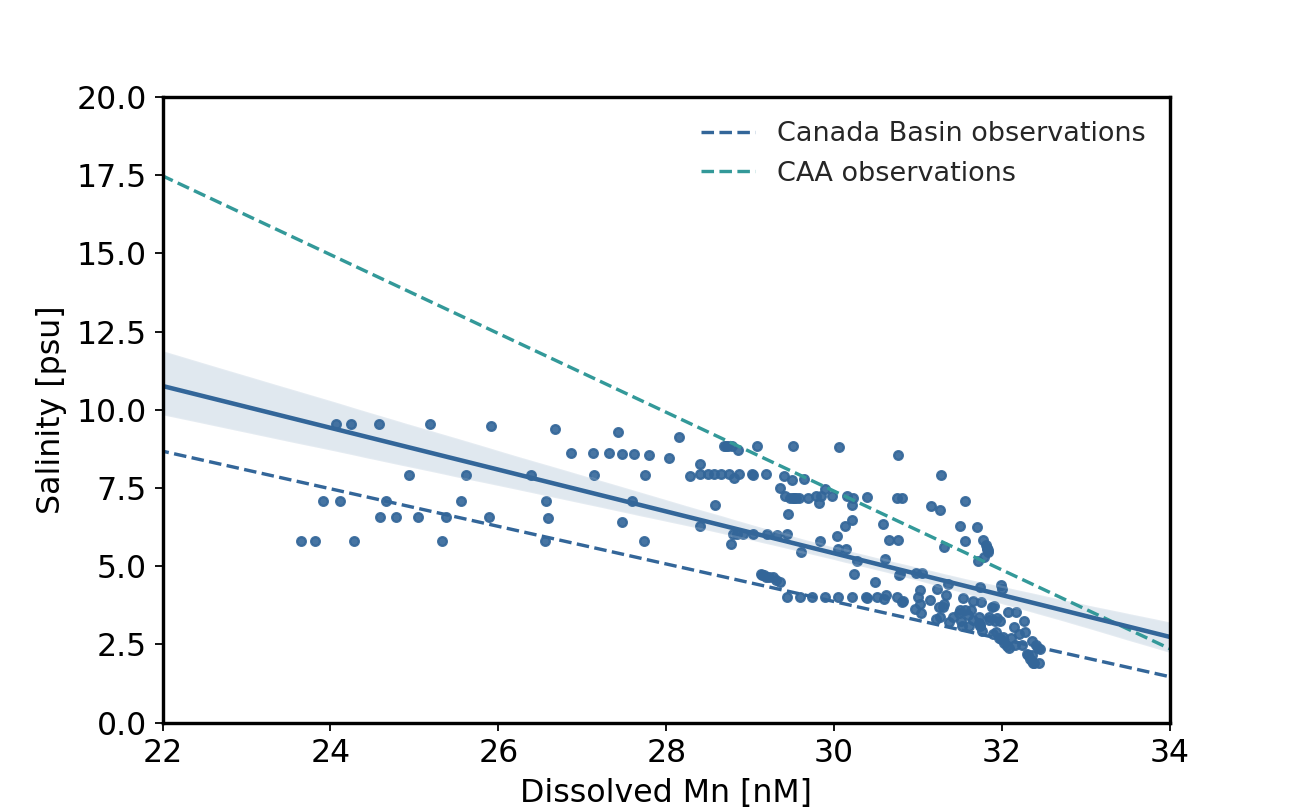

In [30]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
st  = sns.axes_style("whitegrid")

color_CB  = '#336699'
color_CAA = '#339999'

with st:
    # Observations:
    sns.lineplot(S_obs, dmn_obs_CB, linewidth=1.5, color=color_CB, label='Canada Basin observations')
    sns.lineplot(S_obs, dmn_obs_CAA, linewidth=1.5, color=color_CAA, label='CAA observations')
    ax.lines[0].set_linestyle("--")
    ax.lines[1].set_linestyle("--")
    
    ax.set(xlim=(22, 34), ylim=(0, 20))
    
    # Model:
    sns.regplot(np.append(S_CB, S_CAA), np.append(dmn_CB, dmn_CAA), color=color_CB, \
                line_kws={"linewidth":2.0}, scatter_kws={"s": 15, 'alpha':0.9}, ax=ax)
#     sns.regplot(S_CB,  dmn_CB,  color=color_CB, \
#                 line_kws={"linewidth":2.0}, scatter_kws={"s": 15, 'alpha':0.9})

    ax.set_xlabel('Dissolved Mn [nM]', fontsize=14)
    ax.set_ylabel('Salinity [psu]',fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    ax.legend(frameon=False, fontsize=12)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/D1-annual-sea-ice-melt-'+ \
#             str(date.today().strftime('%Y%m%d'))+'.png', bbox_inches='tight',dpi=300)

In [48]:
dmn_sens_CAA = []; S_sens_CAA = [];
dmn_sens_CB  = []; S_sens_CB  = [];

for i,j,n in zip(stn_sensitivity_i, stn_sensitivity_j, stn_sensitivity_n):
    mn_ij1  = mn_model[8, 0, 0:17, int(i), int(j)]*10**9
    S_ij1   = S_model[0, 0:17, int(i)+imin, int(j)+jmin]
    dmn_stn = np.ma.masked_where((tmask[0:17,int(i)+imin,int(j)+jmin] < 0.1), mn_ij1)   
    S_stn   = np.ma.masked_where((tmask[0:17,int(i)+imin,int(j)+jmin] < 0.1), S_ij1)
    
    if n[0:3] == 'CAA':
        dmn_sens_CAA.append(dmn_stn)
        S_sens_CAA.append(S_stn)
    else: 
        dmn_sens_CB.append(dmn_stn)
        S_sens_CB.append(S_stn)
        
dmn_sensitivity_CAA = np.array(dmn_sens_CAA).flatten(); S_sensitivity_CAA = np.array(S_sens_CAA).flatten();
dmn_sensitivity_CB  = np.array(dmn_sens_CB).flatten();  S_sensitivity_CB  = np.array(S_sens_CB).flatten();

In [49]:
S_sensitivity_CAA[S_sensitivity_CAA < 0.1]     = np.nan
dmn_sensitivity_CAA[dmn_sensitivity_CAA < 0.1] = np.nan
S_sensitivity_CB[S_sensitivity_CB < 0.1]       = np.nan
dmn_sensitivity_CB[dmn_sensitivity_CB < 0.1]   = np.nan

<IPython.core.display.Javascript object>


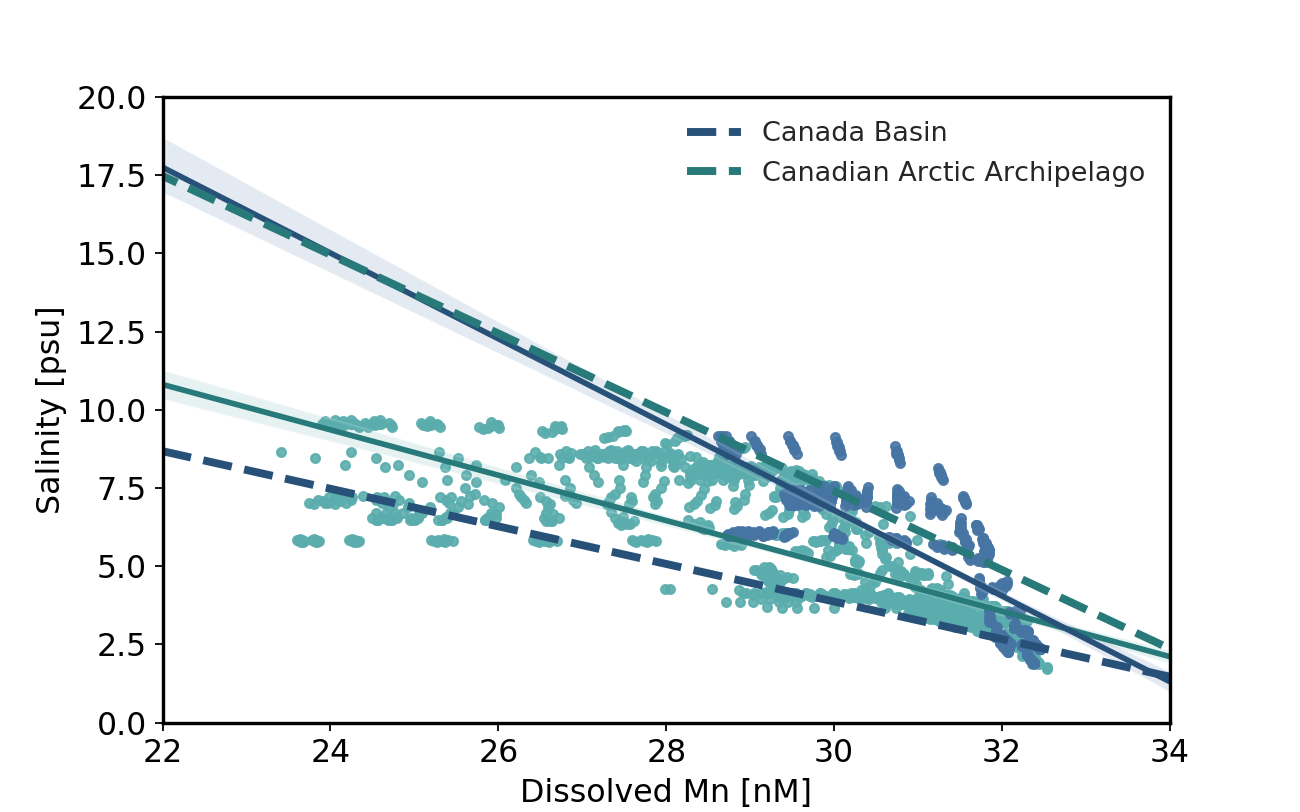

In [50]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
st  = sns.axes_style("white")

color_CB        = '#336699'
color_CB_dark   = '#28517a'
color_CB_light  = '#4775a3'
color_CAA       = '#339999'
color_CAA_dark  = '#287a7a'
color_CAA_light = '#5badad'

with st:    
    
    ax.set(xlim=(22, 34), ylim=(0, 20))
    # Model:
    sns.regplot(S_sensitivity_CAA, dmn_sensitivity_CAA, truncate=False, robust=True, \
                     color=color_CAA_light, line_kws={"linewidth":2.5}, scatter_kws={"s": 15, 'alpha':0.9}, ax=ax)
    sns.regplot(S_sensitivity_CB, dmn_sensitivity_CB, truncate=False, robust=True, \
                color=color_CB_light, line_kws={"linewidth":2.5}, scatter_kws={"s": 15, 'alpha':0.9}, ax=ax)
    ax.lines[0].set_color(color_CAA_dark)
    ax.lines[1].set_color(color_CB_dark)

    # Observations:
    sns.lineplot(S_obs, dmn_obs_CB, label='Canada Basin', linewidth=3.5, color=color_CB_dark, ax=ax)
    sns.lineplot(S_obs, dmn_obs_CAA, label='Canadian Arctic Archipelago', linewidth=3.5, color=color_CAA_dark, ax=ax)
    ax.lines[2].set_linestyle("--")
    ax.lines[3].set_linestyle("--")
    
    ax.set_xlabel('Dissolved Mn [nM]', fontsize=14)
    ax.set_ylabel('Salinity [psu]',fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    ax.legend(frameon=False, fontsize=12)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/A4-salinity-mn-'+ \
#             str(date.today().strftime('%Y%m%d'))+'.png', bbox_inches='tight',dpi=300)

<IPython.core.display.Javascript object>


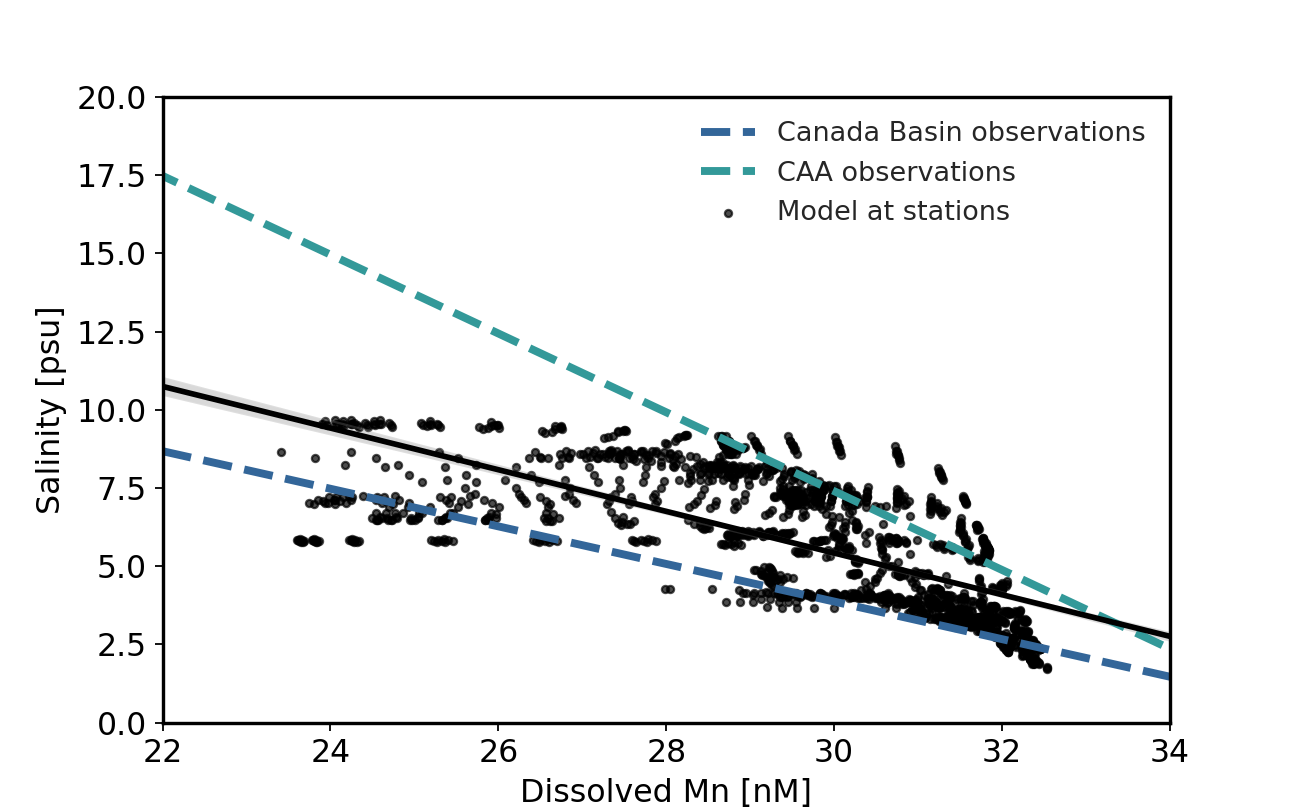

In [47]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
st  = sns.axes_style("whitegrid")

color_CB  = '#336699'
color_CAA = '#339999'

with st:
    # Observations:
    sns.lineplot(S_obs, dmn_obs_CB, linewidth=3.5, color=color_CB, label='Canada Basin observations')
    sns.lineplot(S_obs, dmn_obs_CAA, linewidth=3.5, color=color_CAA, label='CAA observations')
    ax.lines[0].set_linestyle("--")
    ax.lines[1].set_linestyle("--")
    
    ax.set(xlim=(22, 34), ylim=(0, 20))
    
    # Model:
    sns.regplot(np.append(S_sensitivity_CB, S_sensitivity_CAA), \
                np.append(dmn_sensitivity_CB, dmn_sensitivity_CAA), color='k', \
                line_kws={"linewidth":2.5}, scatter_kws={"s": 10, 'alpha':0.7}, ax=ax, \
                label='Model at stations')
#     sns.regplot(S_CB,  dmn_CB,  color=color_CB, \
#                 line_kws={"linewidth":2.0}, scatter_kws={"s": 15, 'alpha':0.9})

    ax.set_xlabel('Dissolved Mn [nM]', fontsize=14)
    ax.set_ylabel('Salinity [psu]',fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    ax.legend(frameon=False, fontsize=12)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/D1-annual-sea-ice-melt-'+ \
#             str(date.today().strftime('%Y%m%d'))+'.png', bbox_inches='tight',dpi=300)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(S_obs, dmn_obs1, '--g', linewidth=2.0)
ax.plot(S_obs, dmn_obs2, '--b', linewidth=2.0)

names = ['CAA1','CAA2','CAA3','CAA4','CAA5','CAA6','CAA7','CAA8','CAA9', \
            'CB1','CB2','CB3','CB4']
for name in names:
    dmn_stn, S_stn = model_data(name)
    if name[0:3] == 'CAA':
        ax.plot(S_stn, dmn_stn, '.b', markersize=8)
    else:
        ax.plot(S_stn, dmn_stn, '.g', markersize=8)

ax.plot([0,0],[0,0], '--b', linewidth=2.0, label='Observations CAA Manuel')
ax.plot([0,0],[0,0], '--g', linewidth=2.0, label='Observations CB Manuel')
ax.plot([0,0],[0,0], '-b', linewidth=2.0, label='Model CAA')
ax.plot([0,0],[0,0], '-g', linewidth=2.0, label='Model CB')

ax.set_title('Upper 40 m of water column')
ax.set_xlim([24, 35])
ax.set_ylim([0, 25])
ax.set_xlabel('Salinity [psu]')
ax.set_ylabel(r'Dissolved Mn [nmol L$^{-1}$]')
ax.legend(frameon=False, fontsize=12)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/salinity_dmn.png')

##### Figure for Mn-S in the full domain

Seperate Canada Basin and CAA

In [51]:
x_ind = np.arange(1620, 2100, 1)
y_ind = (-7/8)*x_ind + 1517 + 700

CB_indx = []
CB_indy = []

for index in range(0,len(x_ind)):
    CB_x = np.arange(x_ind[index],2180,1)
    CB_y = np.ones(CB_x.shape)*y_ind[index]
    
    CB_indx = np.append(CB_x, CB_indx)
    CB_indy = np.append(CB_y, CB_indy)

In [52]:
# Separate Canada Basin and the CAA:
mask_ini_CB  = np.zeros((isize,jsize))
mask_ini_CAA = np.ones((isize,jsize))

for i, j in zip(CB_indx, CB_indy):
    mask_ini_CB[int(i-imin),int(j-jmin)]  = 1
    mask_ini_CAA[int(i-imin),int(j-jmin)] = 0
    
mask_ini_CB[150:-1 ,-8:-1] = 1
mask_ini_CAA[150:-1,-8:-1] = 0

In [53]:
mask_CB  = np.tile(mask_ini_CB , (17,1,1))
mask_CAA = np.tile(mask_ini_CAA, (17,1,1))

Separate salinity and mn results based on these definitons.

In [54]:
S_CB  = np.ma.masked_where(mask_CB==0 , S_model[0,0:17,imin:imax,jmin:jmax])
S_CAA = np.ma.masked_where(mask_CAA==0, S_model[0,0:17,imin:imax,jmin:jmax])

mn_CB  = np.ma.masked_where(mask_CB==0 , mn_model[month,0,0:17,:,:]*10**9)
mn_CAA = np.ma.masked_where(mask_CAA==0, mn_model[month,0,0:17,:,:]*10**9)

In [55]:
S_CB_plot  = S_CB[8:-1,:,:].filled(fill_value=np.nan).flatten()
S_CAA_plot = S_CAA[8:-1,:,:].filled(fill_value=np.nan).flatten()

mn_CB_plot  = mn_CB[8:-1,:,:].filled(fill_value=np.nan).flatten()
mn_CAA_plot = mn_CAA[8:-1,:,:].filled(fill_value=np.nan).flatten()

In [56]:
S_CB_plot[S_CB_plot < 0.1]     = np.nan
S_CAA_plot[S_CAA_plot < 0.1]   = np.nan

mn_CB_plot[mn_CB_plot < 0.1]   = np.nan
mn_CAA_plot[mn_CAA_plot < 0.1] = np.nan

<IPython.core.display.Javascript object>


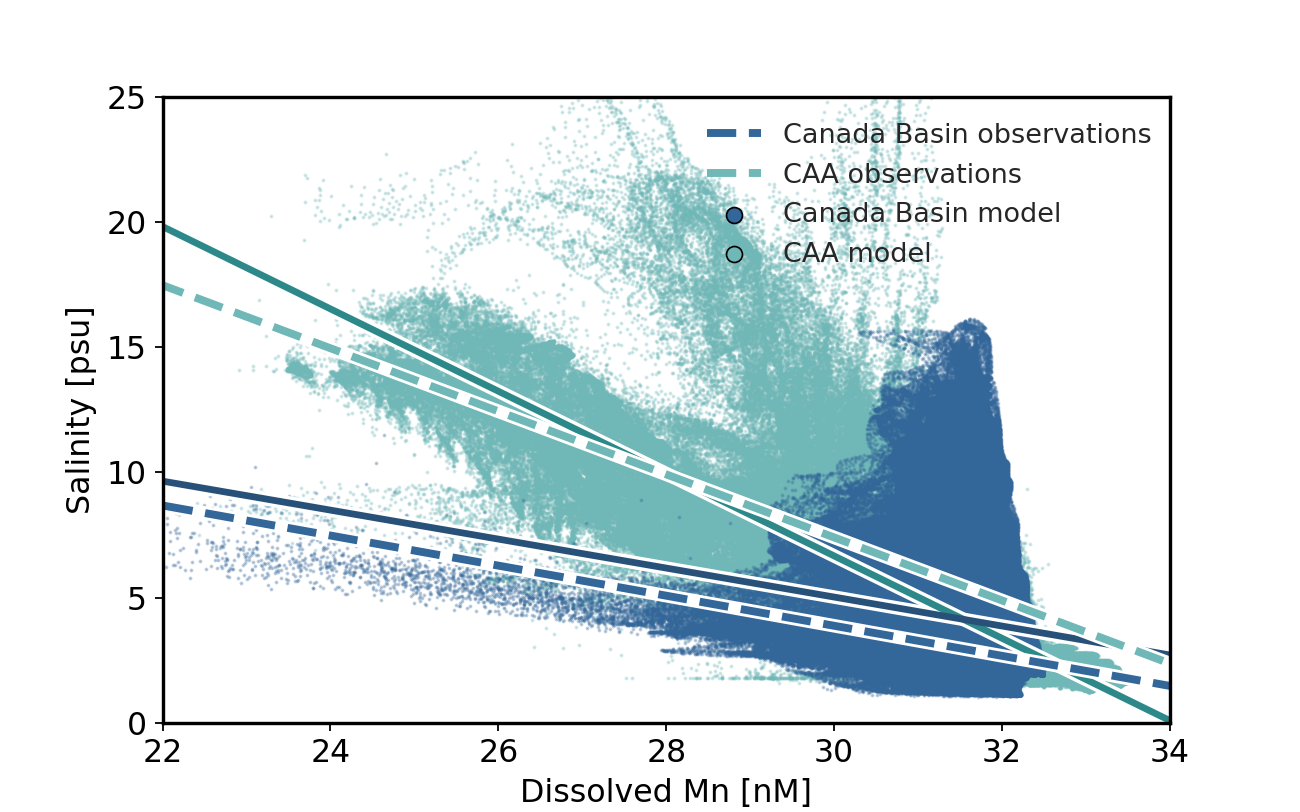

In [57]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
st  = sns.axes_style("whitegrid")

color_CB       = '#336699'
color_CB_dark  = '#28517a'
color_CAA      = '#70b7b7'
color_CAA_dark = '#2d8989'

with st:    
    ax.set(xlim=(22, 34), ylim=(0, 25))
    
    # Model:
    sns.regplot(S_CB_plot , mn_CB_plot, dropna=True, line_kws={"linewidth":6, 'color':'w'}, \
                scatter_kws={"s": 0}, ax=ax)
    sns.regplot(S_CAA_plot, mn_CAA_plot, dropna=True, line_kws={"linewidth":6, 'color':'w'}, \
                scatter_kws={"s": 0}, ax=ax)
    sns.regplot(S_CAA_plot, mn_CAA_plot, dropna=True, line_kws={"linewidth":3.0, 'color':color_CAA_dark}, \
                scatter_kws={"s": 0.5, 'alpha':0.3, 'color': color_CAA}, ax=ax)
    sns.regplot(S_CB_plot , mn_CB_plot, dropna=True, line_kws={"linewidth":3.0, 'color':color_CB_dark}, \
                scatter_kws={"s": 0.5, 'alpha':0.3, 'color':color_CB}, ax=ax)

    # Observations:
    sns.lineplot(S_obs, dmn_obs_CB , linewidth=6, color='w')
    sns.lineplot(S_obs, dmn_obs_CAA, linewidth=6, color='w')
    sns.lineplot(S_obs, dmn_obs_CB , linewidth=3.5, color=color_CB , label='Canada Basin observations')
    sns.lineplot(S_obs, dmn_obs_CAA, linewidth=3.5, color=color_CAA, label='CAA observations')
    ax.lines[6].set_linestyle("--")
    ax.lines[7].set_linestyle("--")
    
    sns.scatterplot([0,0], [0,0], s=50, color=color_CB, label='Canada Basin model', edgecolor='k')
    sns.scatterplot([0,0], [0,0], s=50, color=color_CAA, label='CAA model', edgecolor='k')
    
    ax.set_xlabel('Dissolved Mn [nM]', fontsize=14)
    ax.set_ylabel('Salinity [psu]',fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    ax.legend(loc=(0.53, 0.71), frameon=False, fontsize=12)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/A4-Mn-salinity-ref-'+ \
            str(date.today().strftime('%Y%m%d'))+'.png', bbox_inches='tight',dpi=300)

##### Figure of separation of CB and CAA

In [ ]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

CB_lons = []
CB_lats = []

for i in range(0,len(CB_indx)):
    CB_lons = np.append(mesh_lon[int(CB_indx[i]),int(CB_indy[i])], CB_lons)
    CB_lats = np.append(mesh_lat[int(CB_indx[i]),int(CB_indy[i])], CB_lats)

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 
res=10
proj1.plot(x_sub[imin:imax:res,jmin:jmax:res], y_sub[imin:imax:res,  jmin:jmax:res], 'w-', lw=0.6, zorder=3);
proj1.plot(x_sub[imin:imax:res,jmin:jmax:res].T, y_sub[imin:imax:res,jmin:jmax:res].T, 'w-', lw=0.6, zorder=3);

x_CB, y_CB = proj1(CB_lons, CB_lats)
proj1.plot(x_CB, y_CB, '-r')

In [ ]:
mask_ini_CB  = np.zeros((700,640))
mask_ini_CAA = np.ones((700,640))

for i, j in zip(CB_indx, CB_indy):
    mask_ini_CB[int(i-imin),int(j-jmin)]  = 1
    mask_ini_CAA[int(i-imin),int(j-jmin)] = 0